x_l, x_corr, ecdf_l, ecdf_corr have shapes: (2001,) (1999,) (2001,) (1999,).


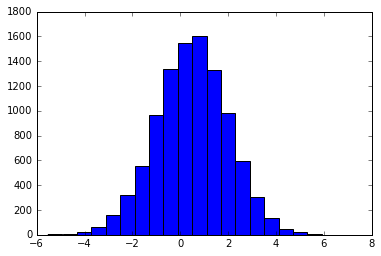

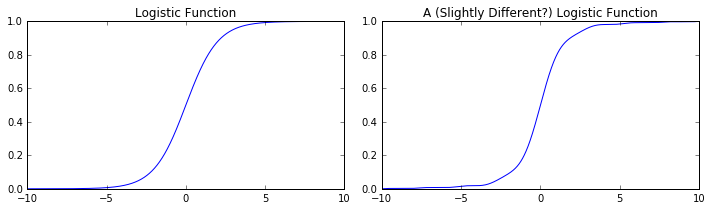

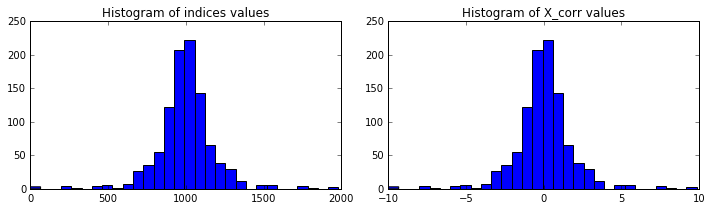

In [1]:
"""
The purpose of this notebook is to test our method on a synthetic, simple (but nontrivial)
example that we can use as a first try at experiments. This is based on Section 5.1 of
"Bayesian Learning via Stochastic Gradient Langevin Dynamics" (2011). We already know the 
trueposterior distribution of this (we can compute a contour plot of that), so it is useful 
to see if our method can obtain the same posterior distribution of the parameters, theta.

We'll generate our data right here. Throughout this code, think of any "theta" variable as
being a 2-D (column) vector. So as far as I can tell:

1. The prior is N(0, diag(10,1)), with a diagonal covariance matrix.
2. The data is generated as a Gaussian Mixture Model. With 50% chance, we draw from
    N(theta[0],2), and with 50% chance, we draw from N(theta[0]+theta[1],2) where theta 
    is the 2-D vector with theta[0] as the first element, and theta[1] as the second. 
    But actually, we *know* the data is drawn from (0,1).
3. What this means is that p(x_i | theta) is going to be based on the *sum* of two 
    different Gaussian PDFs. So when we take logs, we get log(0.5*exp(...)+0.5*exp(...)) 
    so sadly, we cannot eliminate the exponentials.
4. The posterior is the prior times the likelihoods (from (3)) and has a contour plot 
    that we can plot, and which matches the SGLD 2011 paper's plot, so we're OK with
    that. Well, assuming we only use the 100 samples they used (but we need a lot more 
    to see differences!).

Right now, I'm comparing "Our Method" versus the "Cutting the MH" method. Technically, the 
latter should be called "Adaptive Minibatch MH" but the "Cutting the MH" is the title of 
the paper and it is easier to distinguish.
"""

# Import a bunch of stuff ...
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random
from scipy.stats import t
import sys

# VERY important, the number of points. The SGLD paper only used 100, but we need more.
N = 10000

# Generate the data according to Section 5.1 of "Bayesian Learning via SGLD" (2011).
sigma1_sq = 10
sigma2_sq = 1
sigmax_sq = 2
theta1 = 0
theta2 = 1

# Generate the data matrix. Note that the np.random.normal(...) requires STD (not VAR).
X = np.zeros(N)
for i in xrange(N):
    u = np.random.random()
    if (u < 0.5):
        X[i] = np.random.normal(theta1, np.sqrt(sigmax_sq))
    else:
        X[i] = np.random.normal(theta1+theta2, np.sqrt(sigmax_sq))

# Visualize the data (strictly as a sanity check; we don't need to see it).
plt.figure()
plt.hist(X, bins=20)

# Load some of Haoyu's stuff in advance. This will pre-load in the cdf of two functions:
# the logistic (ecdf_l) and the X_correction (ecdf_corr). The x_l and x_corr stuff are
# just arrays of x-values from -10 to 10, spaced out by 0.01, so that it discretizes the
# distribution and we can obtain a CDF value, which will help us determine whether to 
# accept a proposal or not.
import scipy.io
from bisect import bisect
mat = scipy.io.loadmat('ecdf.mat')
x_l = mat['x_l'][0]
x_corr = mat['x_corr'][0]
ecdf_l = mat['ecdf_l'][0]
ecdf_corr = mat['ecdf_corr'][0]
print("x_l, x_corr, ecdf_l, ecdf_corr have shapes: {} {} {} {}.".format(
    x_l.shape, x_corr.shape, ecdf_l.shape, ecdf_corr.shape))

# Visualize x_l, x_corr, ecdf_l, and ecdf_corr
fig, axarr = plt.subplots(1,2, figsize=(10, 3))
axarr[0].plot(x_l, ecdf_l)
axarr[0].set_title('Logistic Function')
axarr[1].plot(x_corr, ecdf_corr)
axarr[1].set_title('A (Slightly Different?) Logistic Function')
plt.tight_layout()

"""
See what's happening? We generate a number between (0,1) and find the index within the range
[-10,10] that would lead to that number, a value which can be anywhere from 0 to 2000 (roughly).
The vast majority of those indices will be around 1000, plus or minus 100. Then we use x_corr to
get the final values we get. Note that x_corr only goes from (-10,10) but I guess that's OK as
we're never going to get to those ending points.
"""

uniform_nums = np.linspace(0,1,1000)
bisections2 = []
ecdfs2 = []
for k in uniform_nums:
    if bisect(ecdf_corr,k) < 1999:
        bisections2.append(bisect(ecdf_corr, k))
        ecdfs2.append(x_corr[bisect(ecdf_corr, k)])
fig, axarr = plt.subplots(1,2, figsize=(10, 3))
axarr[0].hist(bisections2,bins=30)
axarr[0].set_title('Histogram of indices values')
axarr[1].hist(ecdfs2,bins=30)
axarr[1].set_title("Histogram of X_corr values")
plt.tight_layout()

In [2]:
""" Define some functions. """

def log_f(theta, X, N, T):
    """
    The function 'f' is the posterior:
    
        f(theta) \propto p(\theta) * \prod_{i=1}^N p(x_i | \theta)
    
    There are therefore two components. Also, for speed, I try to vectorize. X is assumed 
    to be of shape (n,) so we can reshape it into (n,1). For obvious reasons, we take logs.
    
    Finally, we need to rescale the log likelihood part by N/len(X), just like what is done 
    in many papers. It helps to rescale the terms so that the prior doesn't overly influence
    values if we have minibatches of data. Here, X can be the full data (size N) or a subset.
    If X is the full data, this scaling has no effect. ALSO ... we have T > 1, a temperature
    parameter so we can decrease this factor as needed to make the distribution warmer. This
    means the distribution becomes flatter. It only affects the likelihood, not the prior.
    
    We use [0,0] because we really get a float in two lists, [[x]], so calling [0,0] gets x.
    """
    scale_and_temp = N / float(len(X) * T)
    
    inverse_covariance = np.array([[0.1,0],[0,1]])
    prior_constant = 1.0 / (2*np.pi*np.sqrt(10))
    prior = np.log(prior_constant) - 0.5*(theta.T).dot(inverse_covariance).dot(theta)
    
    X_all = X.reshape((len(X),1))
    ll_constant = (1.0 / (4*np.sqrt(np.pi)))
    L = ll_constant * (np.exp(-0.25*(X_all-theta[0])**2) + np.exp(-0.25*(X_all-(theta[0]+theta[1]))**2))
    log_likelihood = np.sum(np.log(L)) * scale_and_temp
    
    assert (N / float(len(X))) >= 1
    assert not np.isnan(prior + log_likelihood)
    return (prior + log_likelihood)[0,0]
    

def get_noise(eps):
    """ Returns a 2-D multivariate normal vector with covariance matrix = diag(eps,eps). """
    return (np.random.multivariate_normal(np.array([0,0]), eps*np.eye(2))).reshape((2,1))


def get_delta(theta_c, theta_p, X, N, T):
    """
    Compute the delta which we need to use for testing purposes. With random walk proposals,
    this is just the prior and posterior stuff (not transition probabilities). Also, note
    that we are calling the log_f function, so we will have the same N/len(X) scaling effect 
    mentioned in the log_f function. Finally, remember, with delta, it's (new)/(old).
    
    theta_c is the *current* theta that we may "leave" (old theta)
    theta_p is the *proposed* theta that we might accept (new theta)
    T is the temperature parameter, which is input to the log_f function
    """
    loss_old = log_f(theta_c, X, N, T)
    loss_new = log_f(theta_p, X, N, T)
    assert not np.isnan(loss_new - loss_old)
    return loss_new - loss_old
    

def log_f_prior(theta):
    """
    Returns log p(theta), the prior. Remember, it's returning LOGS. Don't take logs again! 
    This is only used for the "Cutting the MH" method's hypothesis testing.
    """
    cov_inv = np.array([[0.1,0],[0,1]])
    return np.log(1.0/(2*np.pi*np.sqrt(10))) - 0.5*(theta.T).dot(cov_inv).dot(theta)
        
        
def approximate_mh_test(theta_c, theta_p, m, X, N, mu_0, eps_tolerance):
    """
    Cutting the MH's budget.
    
    theta_c is the current \theta
    theta_p is the proposed \theta
    m is the starting minibatch size
    X is the full data matrix
    N is the number of data points in X
    mu_0 is equation 2 from "Cutting the MH" paper, pre-computed
    eps_tolerance is for deciding whether delta is small enough
    
    Returns ('accept', 'size'), where 'accept' is a boolean to indicate if we accept or not,
        while 'size' is the size of the mini-batch we sampled (generally a multiple of m).
    """
    
    accept = False
    done = False
    n = 0
    indices_remaining = set(np.arange(N))
    indices_to_use = set()

    while not done:
        
        # Draw mini-bath without replacement, but keep using same indices we've used before.
        size = np.min([m, N-n])
        n = n + size
        indices_to_use = indices_to_use.union(set(random.sample(indices_remaining, size)))
        indices_remaining = set(np.arange(N)) - set(indices_to_use)
        X_mini = (X[np.array(list(indices_to_use))]).reshape((n,1)) # To enable broadcasting.
        
        # Now compute ell_bar and ell_bar_squared, which rely on the data.
        numerator   = np.exp( -0.25*(X_mini-theta_p[0])**2 ) + np.exp( -0.25*(X_mini-(theta_p[0]+theta_p[1]))**2 )
        denominator = np.exp( -0.25*(X_mini-theta_c[0])**2 ) + np.exp( -0.25*(X_mini-(theta_c[0]+theta_c[1]))**2 )
        log_terms = np.log( numerator / denominator )
        ell_bar = (1.0/n) * np.sum(log_terms)
        ell_bar_squared = (1.0/n) * np.sum(log_terms**2) # Squaring individual terms!
        
        # Let's just be safe and check for NaNs.
        assert not np.isnan(np.sum(numerator))
        assert not np.isnan(np.sum(denominator))
        assert not np.isnan(ell_bar)
        assert not np.isnan(ell_bar_squared)
        
        # Now we have the information needed to compute s_l, s, |t|, and delta.
        # Note that if n == N, we can exit since we know delta should be 0. We have all the data.
        if (n == N):
            delta = 0
        else:           
            s_l = np.sqrt((ell_bar_squared - (ell_bar**2)) * (float(n)/(n-1)))
            s = (s_l / np.sqrt(n)) * np.sqrt(1 - (float(n-1)/(N-1)))
            test_statistic = np.abs((ell_bar - mu_0) / s)
            delta = 1 - t.cdf(test_statistic, n-1)
            assert not np.isnan(delta)
            assert not np.isnan(s)
        
        # Finally, we can test if our hypothesis is good enough.
        if (delta < eps_tolerance):
            if (ell_bar > mu_0):
                accept = True
            done = True
  
    return (accept,n)


# Just as a sanity check, to make sure our function is working.
print("log_f([0,1]) = {}, N = {}".format(log_f(np.array([[0],[1]]), X, N, 1), N))

log_f([0,1]) = -18265.6210461, N = 10000


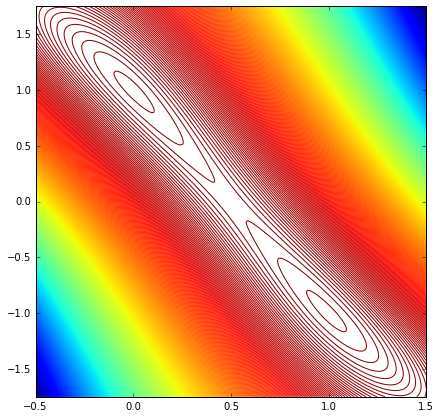

In [3]:
""" 
Heres a contour plot of the posterior, like Figure 1 in the SGLD paper.
The contour plot should roughly show a peak at (0,1) and (1,-1). It may not be exactly that,
but if we generate anywhere more than, say, 1000 points, we should almost certainly see the
two modes. Keep in mind that the 'K' parameter here will affect computation time, though this
gets computed fairly quickly (<2 minutes) even with K=200 and X having 100k data points.
"""

K = 200
T = 1 # Temperature
xlist = np.linspace(-0.5, 1.5, num=K)
ylist = np.linspace(-1.75, 1.75, num=K)
X_a,Y_a = np.meshgrid(xlist, ylist)
Z_a = np.zeros((K,K))
for i in range(K):
    for j in range(K):
        theta = np.array( [[X_a[i,j]],[Y_a[i,j]]] )
        Z_a[i,j] = log_f(theta, X, N, T)        
plt.figure(figsize=(7,7))
plt.contour(X_a,Y_a,Z_a,500)

In [4]:
""" 
Now we run and compare algorithms. Let's start with random walk proposals. 
Actually, to make things easier to see, let's split up the algorithms one by one.
Use capital T, not t, becuase of the student t distribution conflict. Gaaaah.
One "pass" means one "minibatch" in which we evaluate a gradient.
"""

# Some global parameters.
num_passes = 10000
mb_size = 100
rw_eps = 0.1 # the covariance matrix elements for the random walk proposals

    
######################################################
# CUTTING MH BUDGET (should be good, if inefficient) #
######################################################
theta = np.array([[0],[1]])
all_1 = theta
tolerance = 0.05

# For cutting the MH (aka approx MH)
cutting_MH_sizes_accept = []
cutting_MH_sizes_reject = []
cutting_MH_accept = []
cutting_MH_reject = []

for T in range(1,num_passes):
    if (T % int(num_passes/20) == 0):
        print("T={}".format(T))
        
    # Let's deal with the Approx_MH test. This returns a boolean to accept (True) or not.
    # With a random walk proposal, the mu_0 does not depend on the likelihood information.
    theta_new = theta + get_noise(rw_eps)
    prior_old = log_f_prior(theta)
    prior_new = log_f_prior(theta_new)
    log_u = np.log(np.random.random())
    mu_0 = (1.0/N) * (log_u + prior_old - prior_new)    
    (do_we_accept,this_mb_size) = approximate_mh_test(theta, theta_new, mb_size, X, N, mu_0, tolerance)
    
    assert not np.isnan(prior_old)
    assert not np.isnan(prior_new)
    assert not np.isnan(log_u)
    assert not np.isnan(mu_0)
    assert this_mb_size >= mb_size
    
    if do_we_accept:
        theta = theta_new
        all_1 = np.concatenate((all_1,theta), axis=1)
        cutting_MH_sizes_accept.append(this_mb_size)
        cutting_MH_accept.append(T)
    else:
        cutting_MH_sizes_reject.append(this_mb_size)
        cutting_MH_reject.append(T)
        
print("\nDone with Test #1\n")


###################
# OUR MH TEST (1) #
###################
temperature = 1
theta = np.array([[0],[1]])
num_samples_delta = 5 # The number of instances of \Delta we collect
mavg = 0.7 # Moving average
sd = 0
all_2 = theta

# For diagnostical analysis
our_MH_accept_2 = []
our_MH_reject_2 = []
our_sds_2 = []
our_deltas_2 = []
our_xcorrs_2 = []

for T in range(1,num_passes):
    if (T % int(num_passes/20) == 0):
        print("T={}".format(T))
        
    # Let's get *one* new theta, and use multiple mini-batches for this.    
    theta_new = theta + get_noise(rw_eps)
    delta_list = []
    for k in range(num_samples_delta):
        X_minibatch = X[np.random.choice(N, mb_size, replace=False)]
        delta_new = get_delta(theta, theta_new, X_minibatch, N, temperature)
        delta_list.append(delta_new)
        
    # Using this *same* theta, let's get another mini-batch and another delta, but "for real".
    X_mb_real = X[np.random.choice(N, mb_size, replace=False)]
    delta_real = get_delta(theta, theta_new, X_mb_real, N, temperature)
    
    # Moving average update of the standard deviation.
    sd = mavg*sd + (1-mavg)*np.std(np.array(delta_list))
    u = np.random.random()
    X_corr = x_corr[bisect(ecdf_corr, u)]
    X_corr = X_corr * sd
    
    # Gather data for diagnostics.
    our_deltas_2.append(delta_real)
    our_sds_2.append(sd)
    our_xcorrs_2.append(X_corr)
    
    # Now *finally* do the test!
    if (X_corr + delta_real > 0):
        theta = theta_new
        all_2 = np.concatenate((all_2,theta), axis=1)
        our_MH_accept_2.append(T)
    else:
        our_MH_reject_2.append(T)
        
print("\nDone with Test #2\n")

        
###################
# OUR MH TEST (3) #
###################
temperature = 10
theta = np.array([[0],[1]])
num_samples_delta = 5 # The number of instances of \Delta we collect
mavg = 0.7 # Moving average
sd = 0
all_3 = theta

# For diagnostical analysis
our_MH_accept_3 = []
our_MH_reject_3 = []
our_sds_3 = []
our_deltas_3 = []
our_xcorrs_3 = []

for T in range(1,num_passes):
    if (T % int(num_passes/20) == 0):
        print("T={}".format(T))
        
    # Let's get *one* new theta, and use multiple mini-batches for this.    
    theta_new = theta + get_noise(rw_eps)
    delta_list = []
    for k in range(num_samples_delta):
        X_minibatch = X[np.random.choice(N, mb_size, replace=False)]
        delta_new = get_delta(theta, theta_new, X_minibatch, N, temperature)
        delta_list.append(delta_new)
        
    # Using this *same* theta, let's get another mini-batch and another delta, but "for real".
    X_mb_real = X[np.random.choice(N, mb_size, replace=False)]
    delta_real = get_delta(theta, theta_new, X_mb_real, N, temperature)
    
    # Moving average update of the standard deviation.
    sd = mavg*sd + (1-mavg)*np.std(np.array(delta_list))
    u = np.random.random()
    X_corr = x_corr[bisect(ecdf_corr, u)]
    X_corr = X_corr * sd

    # Gather data for diagnostics.
    our_deltas_3.append(delta_real)
    our_sds_3.append(sd)
    our_xcorrs_3.append(X_corr)
    
    # Now *finally* do the test!
    if (X_corr + delta_real > 0):
        theta = theta_new
        all_3 = np.concatenate((all_3,theta), axis=1)
        our_MH_accept_3.append(T)
    else:
        our_MH_reject_3.append(T)
        
print("\nDone with Test #3\n")


###################
# OUR MH TEST (4) #
###################
temperature = 100
theta = np.array([[0],[1]])
num_samples_delta = 5 # The number of instances of \Delta we collect
mavg = 0.7 # Moving average
sd = 0
all_4 = theta

# For diagnostical analysis
our_MH_accept_4 = []
our_MH_reject_4 = []
our_sds_4 = []
our_deltas_4 = []
our_xcorrs_4 = []

for T in range(1,num_passes):
    if (T % int(num_passes/20) == 0):
        print("T={}".format(T))
        
    # Let's get *one* new theta, and use multiple mini-batches for this.    
    theta_new = theta + get_noise(rw_eps)
    delta_list = []
    for k in range(num_samples_delta):
        X_minibatch = X[np.random.choice(N, mb_size, replace=False)]
        delta_new = get_delta(theta, theta_new, X_minibatch, N, temperature)
        delta_list.append(delta_new)
        
    # Using this *same* theta, let's get another mini-batch and another delta, but "for real".
    X_mb_real = X[np.random.choice(N, mb_size, replace=False)]
    delta_real = get_delta(theta, theta_new, X_mb_real, N, temperature)
    
    # Moving average update of the standard deviation.
    sd = mavg*sd + (1-mavg)*np.std(np.array(delta_list))
    u = np.random.random()
    X_corr = x_corr[bisect(ecdf_corr, u)]
    X_corr = X_corr * sd

    # Gather data for diagnostics.
    our_deltas_4.append(delta_real)
    our_sds_4.append(sd)
    our_xcorrs_4.append(X_corr)
    
    # Now *finally* do the test!
    if (X_corr + delta_real > 0):
        theta = theta_new
        all_4 = np.concatenate((all_4,theta), axis=1)
        our_MH_accept_4.append(T)
    else:
        our_MH_reject_4.append(T)
        
print("\nDone with Test #4\n")


#####################################################
# All done. Let's print some interesting statistics #
#####################################################
print("\nAll done!")
print("(Cutting MH) accepted {} times, rejected {} times".
      format(len(cutting_MH_accept), len(cutting_MH_reject)))
print("(2) (Our MH) accepted {} times, rejected {} times".
      format(len(our_MH_accept_2), len(our_MH_reject_2)))
print("(3) (Our MH) accepted {} times, rejected {} times".
      format(len(our_MH_accept_3), len(our_MH_reject_3)))
print("(4) (Our MH) accepted {} times, rejected {} times".
      format(len(our_MH_accept_4), len(our_MH_reject_4)))

T=500
T=1000
T=1500
T=2000
T=2500
T=3000
T=3500
T=4000
T=4500
T=5000
T=5500
T=6000
T=6500
T=7000
T=7500
T=8000
T=8500
T=9000
T=9500

Done with Test #1

T=500
T=1000
T=1500
T=2000
T=2500
T=3000
T=3500
T=4000
T=4500
T=5000
T=5500
T=6000
T=6500
T=7000
T=7500
T=8000
T=8500
T=9000
T=9500

Done with Test #2

T=500
T=1000
T=1500
T=2000
T=2500
T=3000
T=3500
T=4000
T=4500
T=5000
T=5500
T=6000
T=6500
T=7000
T=7500
T=8000
T=8500
T=9000
T=9500

Done with Test #3

T=500
T=1000
T=1500
T=2000
T=2500
T=3000
T=3500
T=4000
T=4500
T=5000
T=5500
T=6000
T=6500
T=7000
T=7500
T=8000
T=8500
T=9000
T=9500

Done with Test #4


All done!
(Cutting MH) accepted 773 times, rejected 9226 times
(2) (Our MH) accepted 3285 times, rejected 6714 times
(3) (Our MH) accepted 3318 times, rejected 6681 times
(4) (Our MH) accepted 3332 times, rejected 6667 times


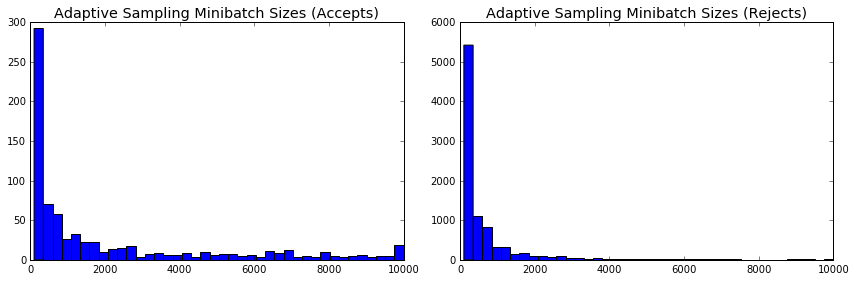

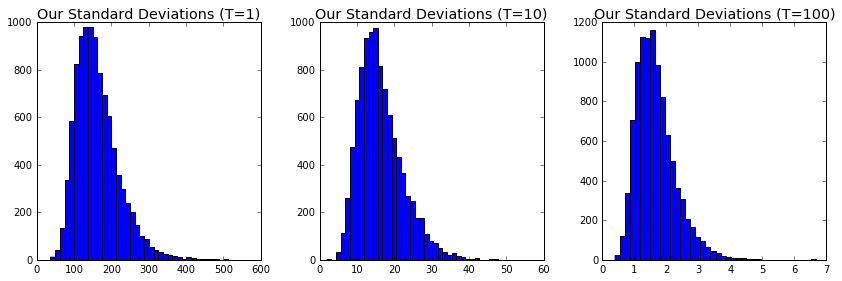

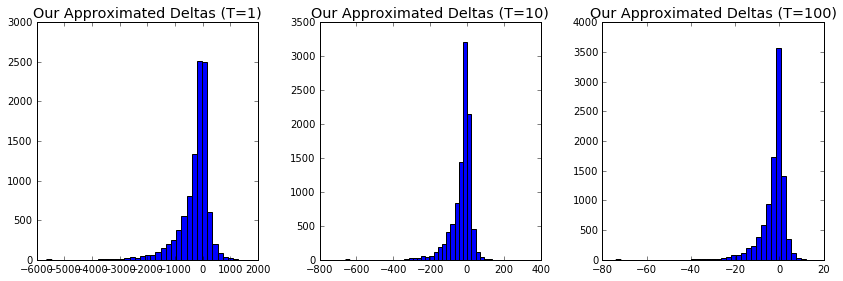

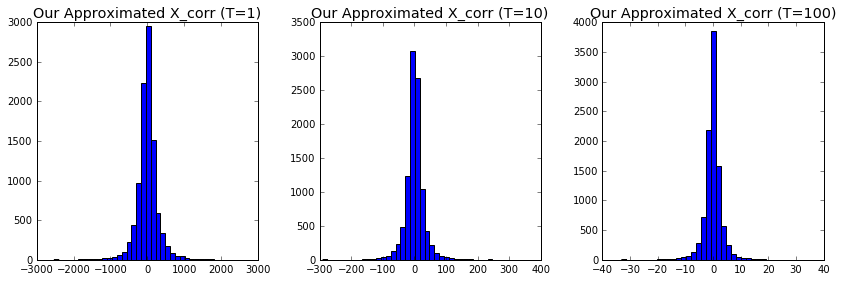

In [18]:
""" Plot results. """

# Get some histograms of cutting MH budgets
fig, axarr = plt.subplots(1,2, figsize=(12, 4))
axarr[0].set_title("Adaptive Sampling Minibatch Sizes (Accepts)", size="x-large")
axarr[0].hist(cutting_MH_sizes_accept, bins=40)
axarr[1].set_title("Adaptive Sampling Minibatch Sizes (Rejects)", size="x-large")
axarr[1].hist(cutting_MH_sizes_reject, bins=40)
plt.tight_layout()
plt.savefig('adaptive_sampling_sizes_v01.png', dpi=200)

# A plot for our standard deviations.
fig, axarr = plt.subplots(1,3, figsize=(12, 4))
axarr[0].set_title("Our Standard Deviations (T=1)", size="x-large")
axarr[0].hist(our_sds_2, bins=40)
axarr[1].set_title("Our Standard Deviations (T=10)", size="x-large")
axarr[1].hist(our_sds_3, bins=40)
axarr[2].set_title("Our Standard Deviations (T=100)", size="x-large")
axarr[2].hist(our_sds_4, bins=40)
plt.tight_layout()
plt.savefig('our_sds_v01.png', dpi=200)

# A plot for our deltas.
fig, axarr = plt.subplots(1,3, figsize=(12, 4))
axarr[0].set_title("Our Approximated Deltas (T=1)", size="x-large")
axarr[0].hist(our_deltas_2, bins=40)
axarr[1].set_title("Our Approximated Deltas (T=10)", size="x-large")
axarr[1].hist(our_deltas_3, bins=40)
axarr[2].set_title("Our Approximated Deltas (T=100)", size="x-large")
axarr[2].hist(our_deltas_4, bins=40)
plt.tight_layout()
plt.savefig('our_deltas_v01.png', dpi=200)

# A plot for our x_corrs.
fig, axarr = plt.subplots(1,3, figsize=(12, 4))
axarr[0].set_title("Our Approximated X_corr (T=1)", size="x-large")
axarr[0].hist(our_xcorrs_2, bins=40)
axarr[1].set_title("Our Approximated X_corr (T=10)", size="x-large")
axarr[1].hist(our_xcorrs_3, bins=40)
axarr[2].set_title("Our Approximated X_corr (T=100)", size="x-large")
axarr[2].hist(our_xcorrs_4, bins=40)
plt.tight_layout()
plt.savefig('our_xcorrs_v01.png', dpi=200)

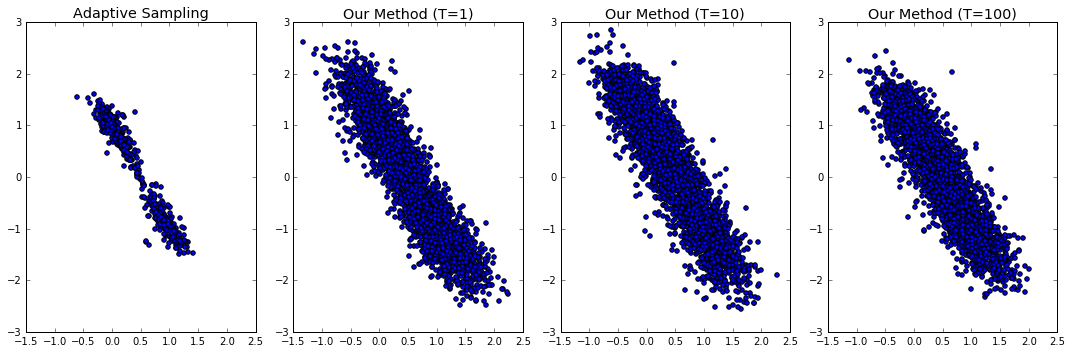

In [17]:
# Plot everything. Be careful that we're using all_x with the correct 'x' values.

fig, axarr = plt.subplots(1,4, figsize=(15, 5))

axarr[0].set_title("Adaptive Sampling", size="x-large")
axarr[0].scatter(all_1[0], all_1[1])
axarr[0].set_xlim([-1.5,2.5])
axarr[0].set_ylim([-3,3])

axarr[1].set_title("Our Method (T=1)", size="x-large")
axarr[1].scatter(all_2[0], all_2[1])
axarr[1].set_xlim([-1.5,2.5])
axarr[1].set_ylim([-3,3])

axarr[2].set_title("Our Method (T=10)", size="x-large")
axarr[2].scatter(all_3[0], all_3[1])
axarr[2].set_xlim([-1.5,2.5])
axarr[2].set_ylim([-3,3])

axarr[3].set_title("Our Method (T=100)", size="x-large")
axarr[3].scatter(all_4[0], all_4[1])
axarr[3].set_xlim([-1.5,2.5])
axarr[3].set_ylim([-3,3])

plt.tight_layout()
plt.savefig('scatter_v01.png', dpi=200)

In [31]:
""" KL divergence test between proposed points and the 'true' posterior. """



" KL divergence test between proposed points and the 'true' posterior. "

In [32]:
# Other stuff, notes from May 11 meeting with John.
# Check values of f(...) functions
# Run with thousands of points
# sd and delta should be around 1
# Test with scales
# Do a lot of diagnostic testing

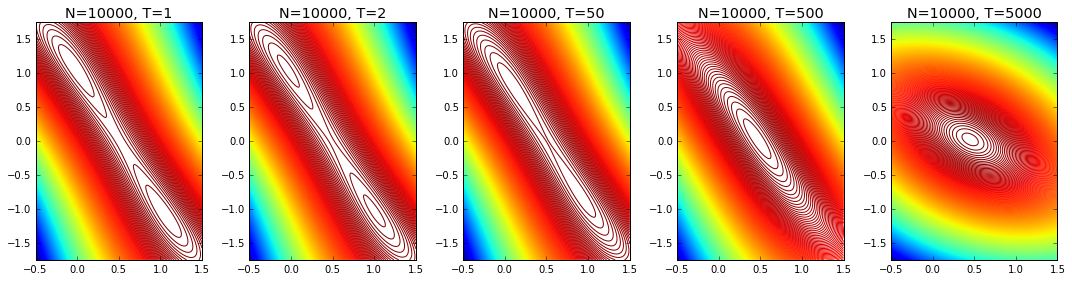

In [14]:
""" Let's actually try investigating the multimodality of the posterior. """

# Generate the data according to Section 5.1 of "Bayesian Learning via SGLD" (2011).
sigma1_sq = 10
sigma2_sq = 1
sigmax_sq = 2
theta1 = 0
theta2 = 1

# Get contour plot parameters here.
K = 200
num_contours = 400

# We need these for the plot, though we'll recreate them inside each get_contours method.
# Make sure the 'linspace' is set correctly!!
xlist = np.linspace(-0.5, 1.5, num=K)
ylist = np.linspace(-1.75, 1.75, num=K)
X_coords,Y_coords = np.meshgrid(xlist, ylist)
    
# Temperature
# T = 1


def get_contours(N, T, K):
    """ Given N and a temperature parameter, generate the Z needed for contour plots. """
    xlist = np.linspace(-0.5, 1.5, num=K)
    ylist = np.linspace(-1.75, 1.75, num=K)
    X_coords,Y_coords = np.meshgrid(xlist, ylist)
    
    # Data generation.
    X = np.zeros(N)    
    for i in xrange(N):
        u = np.random.random()
        if (u < 0.5):
            X[i] = np.random.normal(theta1, np.sqrt(sigmax_sq))
        else:
            X[i] = np.random.normal(theta1+theta2, np.sqrt(sigmax_sq))    
    
    # Getting information for plots.
    Z = np.zeros((K,K))
    for i in range(K):
        for j in range(K):
            theta = np.array( [[X_coords[i,j]],[Y_coords[i,j]]] )
            Z[i,j] = log_f(theta, X, N, T) 
    return Z

# Different contours.
z0 = get_contours(10000, 1, K)
z1 = get_contours(10000, 2, K)
z2 = get_contours(10000, 50, K)
z3 = get_contours(10000, 500, K)
z4 = get_contours(10000, 5000, K)

## Now plot everything!!
fig, axarr = plt.subplots(1,5, figsize=(15, 4))
axarr[0].set_title('N=10000, T=1', size='x-large')
axarr[0].contour(X_coords,Y_coords,z0,num_contours)
axarr[1].set_title('N=10000, T=2', size='x-large')
axarr[1].contour(X_coords,Y_coords,z1,num_contours)
axarr[2].set_title('N=10000, T=50', size='x-large')
axarr[2].contour(X_coords,Y_coords,z2,num_contours)
axarr[3].set_title('N=10000, T=500', size='x-large')
axarr[3].contour(X_coords,Y_coords,z3,num_contours)
axarr[4].set_title('N=10000, T=5000', size='x-large')
axarr[4].contour(X_coords,Y_coords,z4,num_contours)
plt.tight_layout()
plt.savefig('contour_v2.png', dpi=200)